In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import os.path
import subprocess
import pickle
import pandas as pd
from MDAnalysis.analysis import distances
import sys
import math
sys.path.append('../../../string/analysis/scripts')
import plot_parameters_for_paper

In [2]:
def get_gate_dists(md_uni, usual_res = True):
    if usual_res:
        tm1 = md_uni.select_atoms('resid 30-37')
        tm7 = md_uni.select_atoms('resid 289-295')
        tm4 = md_uni.select_atoms('resid 136-145')
        tm10 = md_uni.select_atoms('resid 386-394')
    
    gate_EC_dists = []
    gate_IC_dists = []
    
    for timestep in md_uni.trajectory:
        tm1_com = tm1.center_of_mass()
        tm7_com = tm7.center_of_mass()
        tm4_com = tm4.center_of_mass()
        tm10_com = tm10.center_of_mass()
        
        gate_EC_dists.append(float(distances.distance_array(tm1_com, tm7_com)) / 10)
        gate_IC_dists.append(float(distances.distance_array(tm4_com, tm10_com))/ 10) #keep in nm

    
    gate_EC_dists = np.array(gate_EC_dists)
    gate_IC_dists = np.array(gate_IC_dists)
    
    return gate_EC_dists, gate_IC_dists

# inputs osv

In [3]:
sims = ['influx_apo_all_heavy',\
       'influx_BFRU_all_heavy',\
       'influx_BGLC_all_heavy_restr_sugar']

sim_traj_gro = {'influx_apo_all_heavy':'OUT.equilib.200ns.gro', \
               'influx_BFRU_all_heavy':'OUT.equilib.200ns.BFRU.equilibrated.gro',\
               'influx_BGLC_all_heavy_restr_sugar':'OUT.equilib.200ns.BGLC.equilibrated.gro'}

sim_colors = {'influx_apo_all_heavy':'grey',\
             'influx_BFRU_all_heavy':'green',\
             'influx_BGLC_all_heavy_restr_sugar':'blue'}

In [4]:
sims_unis = {}

skip25 = False

if skip25:
    skip25 = '.skip25.'
else:
    skip25 = '.'

indir = '../../state_by_state_running/targeted_MD'
for sim in sims:
    if 'influx' in sim:
        sims_unis[sim] = mda.Universe(f'{indir}/{sim}/OutOpen-InOpen/{sim_traj_gro[sim]}',\
            f'{indir}/{sim}/OutOpen-InOpen/OutOpen-InOpen{skip25}xtc')
    if 'efflux' in sim:
        sims_unis[sim] = mda.Universe(f'{indir}/{sim}/InOpen-OutOpen/{sim_traj_gro[sim]}',\
            f'{indir}/{sim}/InOpen-OutOpen/InOpen-OutOpen{skip25}xtc')        

In [5]:
sims_gates = {}

for sim,uni in sims_unis.items():
    EC,IC = get_gate_dists(uni)
    
    sims_gates[sim] = [EC,IC]

# functions for different plots

In [6]:
def plot_path(sim, ax, alpha=1, s=5, cmap='plasma', add_indices = None, s_index_scale = 3.2, only_indices = False):
    EC = sims_gates[sim][0]
    IC = sims_gates[sim][1]    

    cmap = plt.cm.get_cmap(cmap)
    colormap = cmap(np.linspace(0,1, len(IC)))

    if not only_indices:
        im = ax.scatter(IC, EC, alpha = alpha, color = colormap, s = s)

    if add_indices:
        im = ax.scatter(IC[add_indices], EC[add_indices], alpha = 1, s = s**s_index_scale,\
                        color = colormap[add_indices], edgecolor = 'black')
    
    
    ax.set_xlim(0.9,1.82)
    ax.set_ylim(0.74, 1.7)
    ax.set_ylabel("Extracellular gate distance (nm)")
    ax.set_xlabel("Intracellular gate distance (nm)")
    ax.set_title(sim)

In [7]:
def plot_path_for_paper(sim, add_indices, ax, n_points_between_states = [4,5,5,5], highlight_models = True):
    
    ## first, colors
    out_open_purple = [0.35, 0.07, 0.64, 1] 
    out_occ_blue = [0.00,0.35,0.90,1.00]
    occ_blue = [0.00,0.59,0.96,1.00]
    in_occ_blue = [0.00,0.64,0.59,1.00]
    in_open_green = [0.00,0.45,0.35,1.00]

    interpolations = [
                      [n_points_between_states[0], out_open_purple, out_occ_blue], \
                      [n_points_between_states[1], out_occ_blue, occ_blue], \
                      [n_points_between_states[2], occ_blue, in_occ_blue], \
                      [n_points_between_states[3], in_occ_blue, in_open_green] 
                        ]
    color_l = np.array([out_open_purple])
    for i in interpolations:
        color_l = np.append(color_l, np.linspace(i[1], i[2], i[0])[1:], axis = 0)
    
    
    
    EC = sims_gates[sim][0]
    IC = sims_gates[sim][1]
    
    
    # actual plotting
    #first made linewidth as long as add_indices, all the same val
    linewidths = np.array([0.5] * len(add_indices))  
    sizes = np.array([150] * len(add_indices))
    
    
    ## first, highlight where the original models come from in a bolder color
    ### this still has some basic assumptions, like that your first frame is starting model
    ##### then, take the cumulative sum of n_points_between_states to get the indices for where
    ###### each model is starting and finishing. These are the points to highlight. -1 for python index
    if highlight_models:
        bold_line = 1.5
        big_size = 250
        linewidths[0] = bold_line
        linewidths[np.cumsum(np.array(n_points_between_states) - 1)] = bold_line
        sizes[0] = big_size
        sizes[np.cumsum(np.array(n_points_between_states) - 1)] = big_size

    ax.scatter(IC, EC, color = '#C4C4C4', alpha = 0.7, s = 100)
    
    ax.scatter(IC[sorted(add_indices)], EC[sorted(add_indices)], \
            edgecolor = 'black', s = sizes, color = color_l, linewidth = linewidths)

    #ax.set_xlim(0.9,1.82)
    #ax.set_ylim(0.74, 1.7)
    ax.set_xlim(0.9,1.65)
    ax.set_ylim(0.75,1.65)
    
    ax.set_ylabel("Extracellular gate distance (nm)")
    ax.set_xlabel("Intracellular gate distance (nm)")
    
    #ax.set_title(sim)

# actual plotting

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD. To see this, set `equal_indices_show = True`

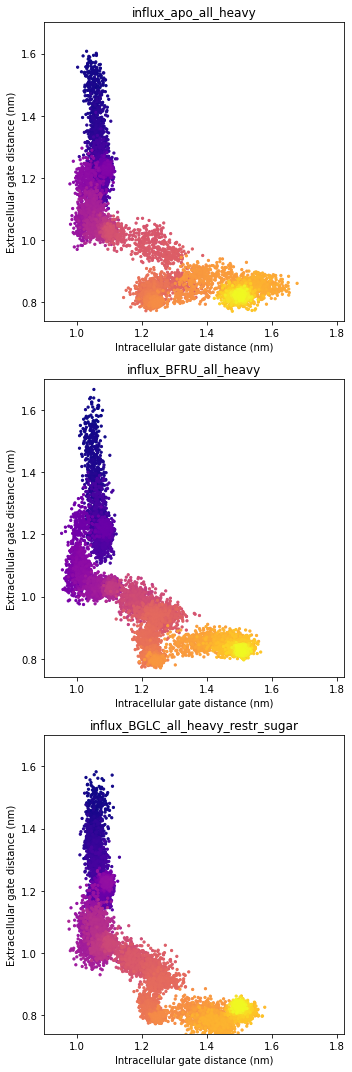

In [8]:
fig, ax = plt.subplots(nrows = len(sims),ncols = 1,figsize=(5,5*len(sims)))

equal_indices_show = False

ax = np.ravel(ax)

for n,sim in enumerate(sims):
    if equal_indices_show:
        equal_indices = np.round(np.linspace(0, len(sims_gates[sim][0])-1, 18))
        equal_indices = np.array(equal_indices, dtype = int)
        plot_path(sim, ax=ax[n], add_indices = list(equal_indices), only_indices=False)
    else:
        plot_path(sim, ax=ax[n])

plt.tight_layout()

# system specific coverage: 

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

## if efflux, bring up code from bottom! 
I decided to do this somewhat system-specific to get a good coverage:

### Influx apo:

**Out Open - Out Occ** - 10550ps (frame 0 - 2637)


**Out Occ - Occ** - 10800ps (frame 2637-5337)

**Occ - In Occ** - 7680ps (frame 5337-7257)

**In Occ - In Open** - 10770ps (frame 7257 - 9950)


**The points you should take for sure are:**
0, 2637, 5337, 7257, and ~~9950~~. (**9859** instead, is not end of sim but is closest to in open) That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 2 from Out Open - Out Occ (500 & 1000)

Take 3 from Out Occ - Occ (2800, 3200, 4200)

Take 3 from Occ - In Occ (5500, 5750, 6300)

Take 3 InOcc - In Open (7350, 7700, 9100)

Only one I am not sure of is InOcc-InOpen. If I take 8000, for this is more open on IC than IN.start.gro. Should I take this as endpoint instead??

### Influx BFRU:

**Out Open - Out Occ** - 8512ps (frame 0 - 2127)


**Out Occ - Occ** - 10800ps (frame 2127-4826) (2700frames)

**Occ - In Occ** - 12640ps (frame 4826-7985) (3160 frames)

**In Occ - In Open** -10264ps (frame 7985 - 10551) (2566 frames)


**The points you should take for sure are:**
0, 2127, 4826,7985, 10550


Take 2 from Out Open - Out Occ ( 300 & 500)

Take 3 from Out Occ - Occ (2250 , 3000, 3200)

Take 3 from Occ - In Occ (4900, 5000, 6300 )

Take 3 InOcc - In Open (8030, 8400,9100 )

### Influx BGLC 

**Out Open - Out Occ** - 13800ps (frame 0 - 3450)

**Out Occ - Occ** - 8804ps (frame 3457-5658)

**Occ - In Occ** - 9628ps (frame 5658 - 8065)

**In Occ - In Open** - 12480ps (frame 8065-11185)

**The points you should take for sure are:**
0, 3450, 5650, 8060, 11180

Take 2 from Out Open - Out Occ (200, 750) 

Take 3 from Out Occ - Occ (3505, 3600, 3950)

Take 3 from Occ - In Occ (5750 6410 7002) 

Take 3 from In Occ - In Open (8250, 8980, 9300) 

In [9]:
sims_specific_indices = {'influx_apo_all_heavy':[0, 2637, 5337, 7257, 9859, \
                                                 500, 1000, 2800, 3200, 4200,\
                                                 5500, 5750, 6300,7350, 7700, 9100],\
                         
                        'influx_BFRU_all_heavy':[0, 300, 500, 2127, 2250, \
                                                 3000, 3200, 4826, 4900, 5000, \
                                                 6300, 7985, 8030, 8400, 9100, 10550], \
                        
                        'influx_BGLC_all_heavy_restr_sugar':[0, 3450, 5650, 8060, 11180,\
                                                             200, 750, 3505, 3600, 3950,\
                                                            5750, 6410, 7002, 8250, 8980, 9300]}

influx_apo_all_heavy
influx_BFRU_all_heavy
influx_BGLC_all_heavy_restr_sugar


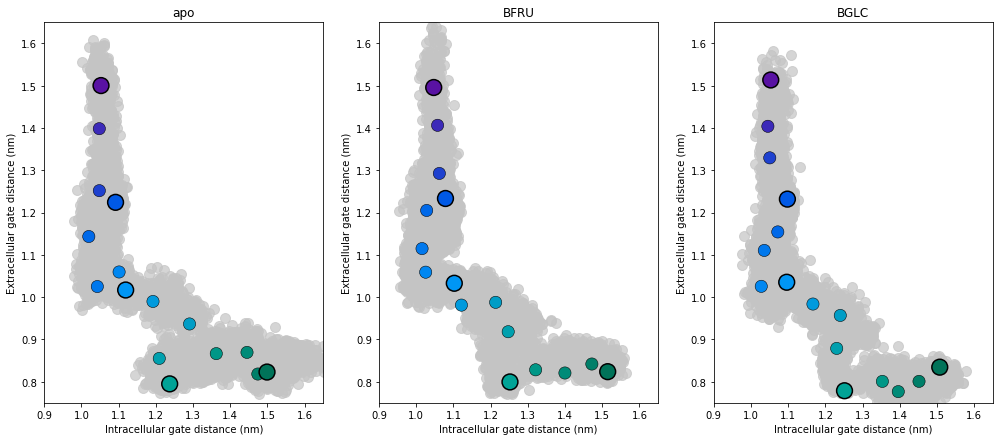

In [22]:
f, ax = plt.subplots(nrows=1,ncols=3,figsize=(17,7))
ax = np.ravel(ax)
for n,sim in enumerate(sims_specific_indices.keys()):
    print(sim)
#sim='influx_BGLC_all_heavy_restr_sugar'
    #plot_path(sim, ax = ax[n], add_indices=sims_specific_indices[sim], only_indices=False)
    plot_path_for_paper(sim, ax = ax[n], add_indices = sims_specific_indices[sim])
    ax[n].set_title(sim.split('_')[1])

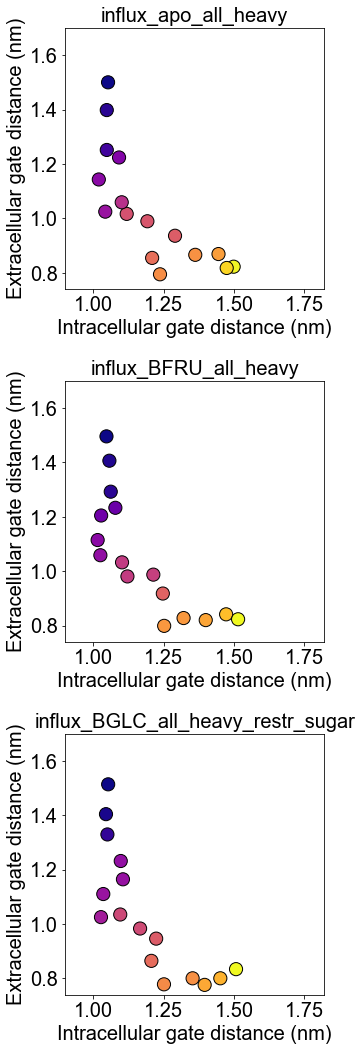

In [171]:
if skip25 == '.':
    fig, ax = plt.subplots(nrows = len(sims),ncols = 1,figsize=(5,5*len(sims)))
    ax = np.ravel(ax)

    for n,sim in enumerate(sims_specific_indices.keys()):
        plot_path(sim, ax=ax[n], add_indices = sims_specific_indices[sim], only_indices=True)

    plt.tight_layout()
else:
    print('Need to enable noskip for this!')

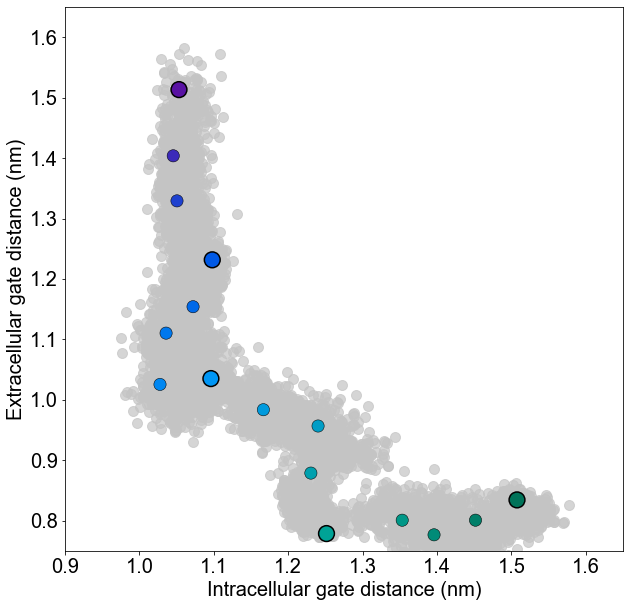

In [215]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_parameters_for_paper.plotting_params()
sim = 'influx_BGLC_all_heavy_restr_sugar'
savefig = True

#for n,sim in enumerate(sims):
plot_path_for_paper(sim, ax = ax, add_indices = sims_specific_indices[sim])
if savefig:
    plt.savefig(f'../images_figs/TMD_bead_choice.{sim}.svg', dpi = 1000)

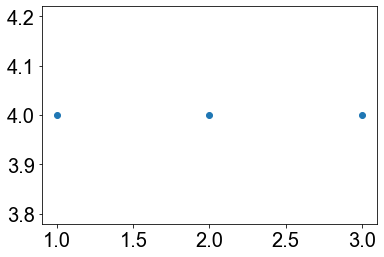

In [14]:
plot_parameters_for_paper.plotting_params()
plt.scatter([1,2,3], [4,4,4])

# efflux system specific info

### Efflux (BFRU):

**In Open - In Occ** -  10008ps (frame 0-2501)


**In Occ - Occ** - 12992 ps (frame 2501-5748) (3248 frames)

**Occ - Out Occ** - 11784 ps (frame 5748-8693) (2946 frames)

**Out Occ - Out Open** - 12440 ps (frame 8693-11803) (3110 frames)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2501, 5748, 8693, and 11803. That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 3 from InOpen-InOcc (300, 750, 1200)

Take 3 from InOcc-Occ (2600, 2800, 4000)

Take 3 from Occ-OutOcc (5810, 7100, 7500) 

Take 2 from OutOcc-OutOpen (8900, 9000)

### Efflux (apo):

**In Open - In Occ** - 9632 ps (frame 0-2407)


**In Occ - Occ** - 8628 ps (frame 2407-4563)

**Occ - Out Occ** - 7772 ps (frame 4563-6505)

**Out Occ - Out Open** - 9136 ps (frame 6505-8789)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2407, 4563, 6505, and 8789. That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 3 from InOpen-InOcc (300, 750, 1200)

Take 3 from InOcc-Occ (2600, 3000, 3800)

Take 3 from Occ-OutOcc (5170, 5300, 5700) This one is weird I know, was difficult to get out of occ-outocc, took quite a bit of pushing until EC gate opened

Take 2 from OutOcc-OutOpen (6705, 6850)